###Load Data


In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import os
import codecs
import json
import csv

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [3]:
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_json.html
# Convert a JSON string to pandas object

X = pd.read_json('./pizza_request_dataset.json')
print ("type(X)", type(X))
print

# set random seed
np.random.seed(0)

# randomly assign 70% to train_data, and 30% to dev_data
msk = np.random.rand(len(X)) <= 0.7
train_data = X[msk]
dev_data = X[~msk]

# create output dataframe Y of train_labels
train_labels = train_data[["requester_received_pizza"]]

# delete train_labels from input dataframe of train_data
del train_data["requester_received_pizza"]

# create output dataframe of dev_labels
dev_labels = dev_data[["requester_received_pizza"]]

# delete dev_labels from input dataframe of dev_data
del dev_data["requester_received_pizza"]

# print (labels, shapes, and feature names
print ("train_labels" )
print ("----------")
print (list(train_labels))
print (train_labels.shape), "/n"
print ("train_data" )
print ("----------")
print (list(train_data))
print (train_data.shape), "/n"


print ("dev_labels") 
print ("----------")
print (list(dev_labels))
print (dev_labels.shape), "/n"

print ("dev_data")
print ("----------")
print (list(dev_data))
print (dev_data.shape), "/n"

# print (percent of train_data and dev_data whose posts led to receipt of pizza
print ("train labels")
print ("----------")
print (np.mean(train_labels)), "/n"
print ("dev labels")
print ("----------")
print (np.mean(dev_labels))

type(X) <class 'pandas.core.frame.DataFrame'>
train_labels
----------
['requester_received_pizza']
(3975, 1)
train_data
----------
['giver_username_if_known', 'in_test_set', 'number_of_downvotes_of_request_at_retrieval', 'number_of_upvotes_of_request_at_retrieval', 'post_was_edited', 'request_id', 'request_number_of_comments_at_retrieval', 'request_text', 'request_text_edit_aware', 'request_title', 'requester_account_age_in_days_at_request', 'requester_account_age_in_days_at_retrieval', 'requester_days_since_first_post_on_raop_at_request', 'requester_days_since_first_post_on_raop_at_retrieval', 'requester_number_of_comments_at_request', 'requester_number_of_comments_at_retrieval', 'requester_number_of_comments_in_raop_at_request', 'requester_number_of_comments_in_raop_at_retrieval', 'requester_number_of_posts_at_request', 'requester_number_of_posts_at_retrieval', 'requester_number_of_posts_on_raop_at_request', 'requester_number_of_posts_on_raop_at_retrieval', 'requester_number_of_subre

##Extract text and tile for train and dev

In [4]:
train_text=train_data['request_text'].as_matrix()
train_title=train_data['request_title'].as_matrix()
# train_all = train_text+train_title

dev_text=dev_data['request_text'].as_matrix()
dev_title=dev_data['request_title'].as_matrix()
# dev_all = dev_text+dev_title

# train_all=train_all.reshape(3975,1)
# dev_all=dev_all.reshape(len(dev_all),1)

In [6]:
# print(train_all.shape)
# print(dev_all.shape)
# print(train_all[1])
# print(train_text.shape)
train_all=np.empty((len(train_text),2),dtype=str)
train_all[:,0]=train_text
train_all[:,1]=train_title

dev_all=np.empty((len(dev_text),2),dtype=str)
dev_all[:,0]=dev_text
dev_all[:,1]=dev_title


In [7]:
print(train_all.shape)
print(dev_all.shape)
print(train_text[0])

(3975, 2)
(1696, 2)
I'm not in College, or a starving artist or anything like that. I've just been a bit unlucky lately. I'm a 36 year old single guy with a job. But rent, and other bills killed me this month. I thought I had enough funds in my account to at least keep me set with Mr. Noodles, I forgot about my monthly banking fee.

I had a small bag of chips Wednesday afternoon, and I get paid Monday, so I'll be fine then.. It's just really painful at this point and food is something I'm constantly thinking about.

I've got a few bucks to get on the bus to work on Saturday, so I can't really use that.

I'm really embarrassed to even be asking like this and I'm not sure how it works, so please be patient with me.

I guess that covers it. Thank you in advance.

Cheers folks.


####helper method

In [8]:
#Roc curve:
from sklearn.metrics import roc_curve, auc

def model_output(pred_probas, F_Score, preds):

    print ("Logistic regression on numeric data: F-Score = %0.4f: "%(F_Score) ) #Sum up Squared Weights
    accuracy = np.where(preds==np.ravel(dev_labels), 1, 0).sum() / float(len(dev_labels))
    print ("Accuracy = %0.4f" % (accuracy))
    print ('accuracy_score: %f' %metrics.precision_score(dev_labels, preds))
    print ('recall_score: %f' %metrics.recall_score(dev_labels, preds))
    print ("roc_auc_score:", metrics.roc_auc_score(dev_labels, preds))

#Create ROC Curve

    fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
    roc_auc = metrics.auc(fpr,tpr)
    plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc='lower right')
    print('auc: %.2f' %roc_auc)
    
    plt.show()

###Test the base model

##Text

In [10]:

def first_preprocessor(s):
    #convert to lowercase
    s=s.lower()
    s=re.sub("[,.!?:;/~*]"," ",s)
    #remove duplicated 0s and 1s
    s=re.sub("[0-9]*","",s)
    #remove number longer than 5 digit
    s=re.sub("[0-9]{5,}","",s)
    #remove stem end with 'ly'
    s=re.sub("ly\s"," ",s)
    #remove plural form
    s=re.sub("s\s"," ",s)
    s=re.sub("s\Z"," ",s)
    #remove _ as the end of word
    s=re.sub("[_]+"," ",s)
    #remove _ as start of the word
    s=re.sub("\s[_]+"," ",s)
    #remove stem end with 'ness'
    s=re.sub("ness\s"," ",s)
    s=re.sub("ing\s"," ",s)
    #remove words that are too short
    s=re.sub("\s[0-9a-z]{1,2}\s"," ",s)
    s=re.sub("\s[0-9a-z]{1,2}\Z"," ",s)

    return s

In [11]:
def train_log(train,dev):
    
    model_LG_func = LogisticRegression(penalty ='l2',C=13)
    model_LG_func.fit(train, np.ravel(train_labels))

#     print('f1_score: %f' %metrics.f1_score(dev_labels,train.predict(dev),average='binary'))
#     print('precision_score: %f' %metrics.precision_score(dev_labels,train.predict(dev)))
#     print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG.predict(dev)))
#     print('accuracy_score: %f' %metrics.accuracy_score(dev_labels,model_LG.predict(dev_matrix_process_text)))

    preds = model_LG_func.predict(dev)
    F_Score = metrics.f1_score(dev_labels, preds, average='binary')
    pred_probas = model_LG_func.predict_proba(dev)

    #Call to display outputs
    model_output(pred_probas, F_Score, preds)
    fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
    roc_auc = metrics.auc(fpr,tpr)
    print(roc_auc)

###CountVector

WIth word prprocessing:

Logistic regression on numeric data: F-Score = 0.2842: 
Accuracy = 0.6733
accuracy_score: 0.328358
recall_score: 0.250569
roc_auc_score: 0.535785931358
auc: 0.53


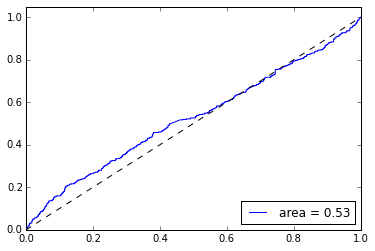

0.52550546099
WIthout word prprocessing:

Logistic regression on numeric data: F-Score = 0.2816: 
Accuracy = 0.6781
accuracy_score: 0.333333
recall_score: 0.243736
roc_auc_score: 0.536744572082
auc: 0.53


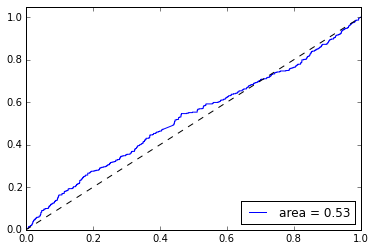

0.528345139655


In [77]:
def empty_preprocessor(s):
    return s


vectorizer_process = CountVectorizer(preprocessor =first_preprocessor,analyzer='word',stop_words='english' )
train_matrix_process_text= vectorizer_process.fit_transform(train_text)
dev_matrix_process_text = vectorizer_process.transform(dev_text)
print('WIth word prprocessing:\n')
train_log(train_matrix_process_text,dev_matrix_process_text)

vectorizer_process = CountVectorizer(preprocessor =empty_preprocessor,analyzer='word',stop_words='english' )
train_matrix_process_text= vectorizer_process.fit_transform(train_text)
dev_matrix_process_text = vectorizer_process.transform(dev_text)
print('WIthout word prprocessing:\n')
train_log(train_matrix_process_text,dev_matrix_process_text)

# model_LG = LogisticRegression(penalty ='l2',C=12)
# model_LG.fit(train_matrix_process_text, np.ravel(train_labels))

# print('f1_score: %f' %metrics.f1_score(dev_labels,model_LG.predict(dev_matrix_process_text),average='binary'))
# print('precision_score: %f' %metrics.precision_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
# print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
# print('accuracy_score: %f' %metrics.accuracy_score(dev_labels,model_LG.predict(dev_matrix_process_text)))

# preds = model_LG.predict(dev_matrix_process_text)
# F_Score = metrics.f1_score(dev_labels, preds, average='binary')
# pred_probas = model_LG.predict_proba(dev_matrix_process_text)

# #Call to display outputs
# model_output(pred_probas, F_Score, preds)



##TF-IDF

Logistic regression on numeric data: F-Score = 0.2036: 
Accuracy = 0.6910
accuracy_score: 0.305936
recall_score: 0.152620
roc_auc_score: 0.515848378919
auc: 0.58


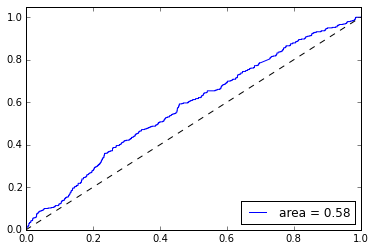

0.577458714117


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [78]:
def empty_preprocessor(s):
    return s


vectorizer_process = TfidfVectorizer(preprocessor =first_preprocessor,analyzer='word',stop_words='english' )
train_matrix_process_text= vectorizer_process.fit_transform(train_text)
dev_matrix_process_text = vectorizer_process.transform(dev_text)

train_log(train_matrix_process_text,dev_matrix_process_text)

# vectorizer_process = TfidfVectorizer(preprocessor =empty_preprocessor,analyzer='word',stop_words='english' )
# train_matrix_process_text= vectorizer_process.fit_transform(train_text)
# dev_matrix_process_text = vectorizer_process.transform(dev_text)

# train_log(train_matrix_process_text,dev_matrix_process_text)


model_LG = LogisticRegression(penalty ='l2',C=1)
model_LG.fit(train_matrix_process_text, np.ravel(train_labels))

# print('f1_score: %f' %metrics.f1_score(dev_labels,model_LG.predict(dev_matrix_process_text),average='binary'))
# print('precision_score: %f' %metrics.precision_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
# print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
# print('accuracy_score: %f' %metrics.accuracy_score(dev_labels,model_LG.predict(dev_matrix_process_text)))

# preds = model_LG.predict(dev_matrix_process_text)
# F_Score = metrics.f1_score(dev_labels, preds, average='binary')
# pred_probas = model_LG.predict_proba(dev_matrix_process_text)

# #Call to display outputs
# model_output(pred_probas, F_Score, preds)
# fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
# roc_auc = metrics.auc(fpr,tpr)
# print(roc_auc)

###take a look at the top cofficient words


In [19]:
print(model_LG.coef_.shape)
# print( abs(model_LG.coef_ [0]))
# print(len(vectorizer_process.vocabulary_))
# print(vectorizer_process.vocabulary_)

model_LG = LogisticRegression(penalty ='l2',C=0.08)
model_LG.fit(train_matrix_process_text, np.ravel(train_labels))

index_good=np.argsort((model_LG.coef_ [0]))[-200:]

df = pd.DataFrame({'Feature': np.array(vectorizer_process.get_feature_names())[index_good], 'coef': np.array(model_LG.coef_ [0])[index_good]})
print(df)

index_bad=np.argsort((model_LG.coef_ [0]))[:200]

df = pd.DataFrame({'Feature': np.array(vectorizer_process.get_feature_names())[index_bad], 'coef': np.array(model_LG.coef_ [0])[index_bad]})
print(df)


# a=np.concatenate((np.array(vectorizer_process.get_feature_names())[index],np.array(model_LG.coef_ [0])[index]), axis=0)
# a= np.array(vectorizer_process.get_feature_names())[index]+np.array(model_LG.coef_ [0])[index]
# print(a)

(1, 10164)
         Feature      coef
0        promise  0.062162
1            ish  0.062471
2           hunt  0.062534
3         havent  0.062573
4          tried  0.063643
5            sav  0.064160
6         butter  0.065006
7            add  0.065180
8             lt  0.065316
9        comment  0.065417
10       kindnes  0.066223
11         payed  0.066655
12         quick  0.066863
13           isn  0.067062
14   anniversary  0.067067
15            ca  0.067622
16        wonder  0.067628
17     community  0.067666
18        receiv  0.067939
19         super  0.068247
20          hurt  0.068444
21         couch  0.068521
22        guilty  0.068556
23         needy  0.068684
24      absolute  0.068742
25       fiancee  0.068972
26        dinner  0.069209
27            gt  0.069228
28        school  0.069246
29          drop  0.069408
..           ...       ...
170       recent  0.164451
171        great  0.166282
172       dollar  0.166326
173          car  0.167082
174         best 

##Try to find the best number of words to include in the model

In [20]:
def empty_preprocessor(s):
    return s

def train_tf_idf(dicts):
    
    vectorizer_process_limit = TfidfVectorizer(preprocessor =first_preprocessor,analyzer='word',stop_words='english',vocabulary=dicts )
    train_matrix_process_text= vectorizer_process_limit.fit_transform(train_text)
    dev_matrix_process_text = vectorizer_process_limit.transform(dev_text)


    model_LG_limit = LogisticRegression(penalty ='l2',C=13)
    model_LG_limit.fit(train_matrix_process_text, np.ravel(train_labels))

    # print('f1_score: %f' %metrics.f1_score(dev_labels,model_LG.predict(dev_matrix_process_text),average='binary'))
    # print('precision_score: %f' %metrics.precision_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
    # print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
    # print('accuracy_score: %f' %metrics.accuracy_score(dev_labels,model_LG.predict(dev_matrix_process_text)))

    preds = model_LG_limit.predict(dev_matrix_process_text)
    F_Score = metrics.f1_score(dev_labels, preds, average='binary')
    pred_probas = model_LG_limit.predict_proba(dev_matrix_process_text)

    #Call to display outputs
#     model_output(pred_probas, F_Score, preds)
    fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
    roc_auc = metrics.auc(fpr,tpr)
    return roc_auc

In [21]:
auc=[]
idx=[]
for i in range(100,4000,40):
    index_good=np.argsort((model_LG.coef_ [0]))[-i:]
    index_bad=np.argsort((model_LG.coef_ [0]))[:i]
    dicts=[]
    dicts=list(np.array(vectorizer_process.get_feature_names())[index_good])+list(np.array(vectorizer_process.get_feature_names())[index_bad])
    auc.append(train_tf_idf(dicts))
    idx.append(i)


 
    


[50 56 30 55 57 51 31 52 54 86 81 58 80 87 85 60 84 38 36 65 82 32 53 49 89
 29 59 88 61 66 62 63 83 79 37 41 67 78 64 39 33 34 68 46 35 40 74 44 70 76
 73 77 72 71 90 45 43 75 18 69 48 95 42 92 96 28 91 47 27 16 20 93 94 17 14
 97 19 24 21 25 23 15 26 22 13 12 10 11  9  8  7  6  2  5  1  4  0  3]
220
0.603130895233


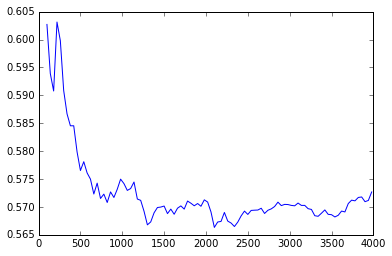

In [22]:
plt.plot(idx,auc)
# plt.show()
print(np.argsort(auc))
print(idx[3])
print(auc[3])


####given the best number of words to include is 220, i picked the top 220 words from each side

In [23]:
for i in [220]:
    index_good=np.argsort((model_LG.coef_ [0]))[-i:]
    index_bad=np.argsort((model_LG.coef_ [0]))[:i]
    dicts=[]
    dicts=list(np.array(vectorizer_process.get_feature_names())[index_good])+list(np.array(vectorizer_process.get_feature_names())[index_bad])
    vectorizer_process_limit = TfidfVectorizer(preprocessor =first_preprocessor,analyzer='word',stop_words='english',vocabulary=dicts )
    train_matrix_process_text= vectorizer_process_limit.fit_transform(train_text)
    dev_matrix_process_text = vectorizer_process_limit.transform(dev_text)

Logistic regression on numeric data: F-Score = 0.2538: 
Accuracy = 0.7123
accuracy_score: 0.386047
recall_score: 0.189066
roc_auc_score: 0.542027063026
auc: 0.62


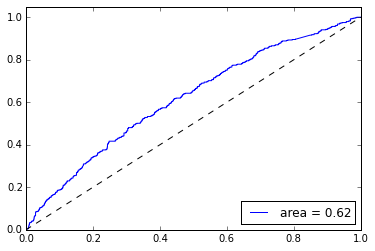

0.616356150432


In [24]:
np.random.seed(0)

# vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = empty_preprocessor)
# word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
# dev_matrix_process = vectorizer_process.transform(dev_all)

a=train_matrix_process_text
b=dev_matrix_process_text

model_LG_L1 = LogisticRegression(penalty ='l1',C=1)#C from the above test
model_LG_L1.fit(a, np.ravel(train_labels))

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)
            
model_LG = LogisticRegression(penalty ='l2',C=13)#C from the above test
model_LG.fit(a[:,index], np.ravel(train_labels))

preds = model_LG.predict(b[:,index])
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')
pred_probas = model_LG.predict_proba(b[:,index])

#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)

##Narrative

In [25]:
desire = re.compile(r'(friend|party|birthday|boyfriend|girlfriend|date|drinks|drunk|wasted|invite|invited|celebrate|celebrating|game|games|movie|beer|crave|craving|gf)', re.IGNORECASE)
family = re.compile(r'(husband|wife|family|parent|parents|mother|father|mom|mum|son|dad|daughter|firstborn|Pregnancy  )', re.IGNORECASE)
job = re.compile(r'(job|unemployment|employment|hire|hired|fired|interview|work)', re.IGNORECASE)
money = re.compile(r'(money|bill|bills|rent|bank|account|paycheck|due|broke|bills|deposit|cash|dollar|dollars|bucks|paid|payed|buy|check|spent|financial|poor|loan|\
credit|budget|day|now|time|week|until|last|month|tonight|today|next|night|when|tomorrow|first|after|while|before|long|hour|Friday|ago|still|due|past|soon|current|years|never|till|yesterday|morning|evening)', re.IGNORECASE)
student = re.compile(r'(college|student|university|finals|study|studying|class|semester|school|roommate|project|tuition|dorm)', re.IGNORECASE)
mood = re.compile(r'(thank|thanks|thankful|appreciate|grateful|gratitude|advance)', re.IGNORECASE) 
holiday = re.compile(r'(anniversary|chirstmas)', re.IGNORECASE)   


In [26]:
def myfunc(a,b):
    if len(a)==0:
        return 0 
    else:
        return len(b.findall(a))/float(len(a))


In [27]:
narrative_all=np.ndarray(shape=(len(train_text),7),dtype=int)
narrative_all_dev=np.ndarray(shape=(len(dev_text),7),dtype=int)

for index,i in enumerate([desire,family,job,money,student,mood,holiday]):
    
    vfunc = np.vectorize(myfunc)
    narrative=vfunc(train_title,i)
    narrative_dev=vfunc(dev_title,i)
    med=np.median(narrative)
    narrative_all[:,index]=np.where(narrative>med,1,0)
    narrative_all_dev[:,index]=np.where(narrative_dev>med,1,0)
#     narrative_all[:,index]=narrative
#     narrative_all_dev[:,index]=narrative_dev

In [28]:
print(narrative_all)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 1 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


(3975, 447)
Logistic regression on numeric data: F-Score = 0.2731: 
Accuracy = 0.7176
accuracy_score: 0.409091
recall_score: 0.205011
roc_auc_score: 0.550795273122
auc: 0.62


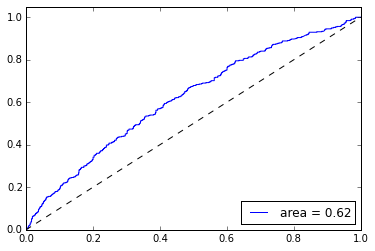

0.618752752241


In [29]:
train_narrative=np.concatenate((train_matrix_process_text.toarray(), narrative_all), axis=1)
dev_narrative=np.concatenate((dev_matrix_process_text.toarray(), narrative_all_dev), axis=1)

print(train_narrative.shape)
# train_log(train_matrix_process_text,dev_matrix_process_text)
# train_log(train_narrative,dev_narrative)
np.random.seed(0)

# vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = empty_preprocessor)
# word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
# dev_matrix_process = vectorizer_process.transform(dev_all)

a=train_narrative
b=dev_narrative

model_LG_L1 = LogisticRegression(penalty ='l1',C=1)#C from the above test
model_LG_L1.fit(a, np.ravel(train_labels))

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)
            
model_LG = LogisticRegression(penalty ='l2',C=13)#C from the above test
model_LG.fit(a[:,index], np.ravel(train_labels))

preds = model_LG.predict(b[:,index])
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')
pred_probas = model_LG.predict_proba(b[:,index])

#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)

##excl_marks


In [30]:
exclmarks = re.compile(r'(!)', re.M)
# holiday    = re.compile(r'(anniversary|chirstmas)', re.IGNORECASE)   
excl_marks=np.ndarray(shape=(len(train_text),1),dtype=int)
excl_marks_dev=np.ndarray(shape=(len(dev_text),1),dtype=int)

for index,i in enumerate([exclmarks]):
    
    vfunc = np.vectorize(myfunc)
    narrative=vfunc(train_title+train_text,i)
    narrative_dev=vfunc(dev_title+dev_text,i)
#     med=np.median(narrative)
    excl_marks[:,index]=np.where(narrative>0,1,0)
    excl_marks_dev[:,index]=np.where(narrative_dev>0,1,0)

(3975, 448)
Logistic regression on numeric data: F-Score = 0.2770: 
Accuracy = 0.7199
accuracy_score: 0.417431
recall_score: 0.207289
roc_auc_score: 0.553127542708
auc: 0.62


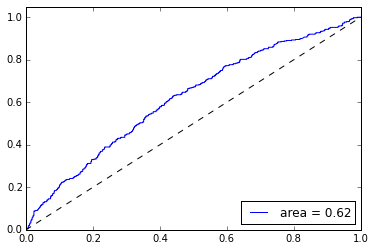

0.619042700286


In [31]:
train_narrative_excl=np.concatenate((train_narrative, excl_marks), axis=1)
dev_narrative_excl=np.concatenate((dev_narrative, excl_marks_dev), axis=1)
print(train_narrative_excl.shape)
# train_log(train_matrix_process_text,dev_matrix_process_text)
# train_log(train_narrative,dev_narrative)
np.random.seed(0)

# vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = empty_preprocessor)
# word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
# dev_matrix_process = vectorizer_process.transform(dev_all)

a=train_narrative_excl
b=dev_narrative_excl

model_LG_L1 = LogisticRegression(penalty ='l1',C=1)#C from the above test
model_LG_L1.fit(a, np.ravel(train_labels))

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)
            
model_LG = LogisticRegression(penalty ='l2',C=13)#C from the above test
model_LG.fit(a[:,index], np.ravel(train_labels))

preds = model_LG.predict(b[:,index])
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')
pred_probas = model_LG.predict_proba(b[:,index])

#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)

In [32]:
train_caps = train_data['request_title'].apply(lambda x: np.where(sum(1 for c in re.split('\W+',x) if c.isupper() and len(c) > 5) > 0, 1,0)).as_matrix()
dev_caps = dev_data['request_title'].apply(lambda x: np.where(sum(1 for c in re.split('\W+',x) if c.isupper() and len(c) > 5) > 0, 1,0)).as_matrix()


In [33]:
train_caps=train_caps.reshape(len(train_caps),1) 
dev_caps=dev_caps.reshape(len(dev_caps),1) 
# train_narrative_excl_cap.shape
# train_cap.shape
# train_narrative_excl_cap.shape

(3975, 449)
Logistic regression on numeric data: F-Score = 0.2774: 
Accuracy = 0.7205
accuracy_score: 0.419355
recall_score: 0.207289
roc_auc_score: 0.553525315183
auc: 0.62


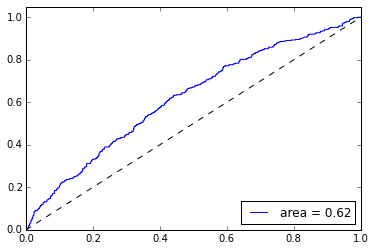

0.619158679504


In [34]:
train_narrative_excl_cap=np.concatenate((train_narrative_excl, train_caps), axis=1)
dev_narrative_excl_cap=np.concatenate((dev_narrative_excl, dev_caps), axis=1)
print(train_narrative_excl_cap.shape)
# train_log(train_matrix_process_text,dev_matrix_process_text)
# train_log(train_narrative,dev_narrative)
np.random.seed(0)

# vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = empty_preprocessor)
# word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
# dev_matrix_process = vectorizer_process.transform(dev_all)

a=train_narrative_excl_cap
b=dev_narrative_excl_cap

model_LG_L1 = LogisticRegression(penalty ='l1',C=1)#C from the above test
model_LG_L1.fit(a, np.ravel(train_labels))

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)
            
model_LG = LogisticRegression(penalty ='l2',C=13)#C from the above test
model_LG.fit(a[:,index], np.ravel(train_labels))

preds = model_LG.predict(b[:,index])
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')
pred_probas = model_LG.predict_proba(b[:,index])

#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)

(3975, 449)
0.644384159413
Logistic regression on numeric data: F-Score = 0.0393: 
Accuracy = 0.7406
accuracy_score: 0.473684
recall_score: 0.020501
roc_auc_score: 0.506272844735
auc: 0.64


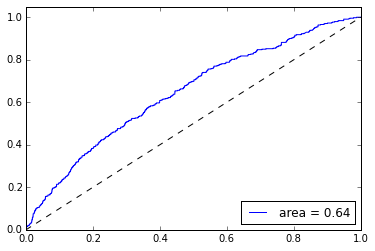

In [73]:
train_narrative_excl_cap=np.concatenate((train_narrative_excl, train_caps), axis=1)
dev_narrative_excl_cap=np.concatenate((dev_narrative_excl, dev_caps), axis=1)
print(train_narrative_excl_cap.shape)
# train_log(train_matrix_process_text,dev_matrix_process_text)
# train_log(train_narrative,dev_narrative)
np.random.seed(0)

# vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = empty_preprocessor)
# word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
# dev_matrix_process = vectorizer_process.transform(dev_all)

a=train_narrative_excl_cap
b=dev_narrative_excl_cap

model_LG_L1 = LogisticRegression(penalty ='l1',C=1)#C from the above test
model_LG_L1.fit(a, np.ravel(train_labels))

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)
            
model_LG = LogisticRegression(penalty ='l2',C=0.26)#C from the above test
model_LG.fit(a[:,index], np.ravel(train_labels))

preds = model_LG.predict(b[:,index])
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')
pred_probas = model_LG.predict_proba(b[:,index])

#Call to display outputs

fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)


In [38]:
train_narrative_excl_cap=np.concatenate((train_narrative_excl, train_caps), axis=1)
dev_narrative_excl_cap=np.concatenate((dev_narrative_excl, dev_caps), axis=1)
print(train_narrative_excl_cap.shape)
# train_log(train_matrix_process_text,dev_matrix_process_text)
# train_log(train_narrative,dev_narrative)
np.random.seed(0)

# vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = empty_preprocessor)
# word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
# dev_matrix_process = vectorizer_process.transform(dev_all)

a=train_narrative_excl_cap
b=dev_narrative_excl_cap

auc=[]
c1=[]
c2=[]
for i in np.arange(0.1,3,0.1):
    for j in np.arange(0.1,5,0.1):
        
        model_LG_L1 = LogisticRegression(penalty ='l1',C=i)#C from the above test 0.7
        model_LG_L1.fit(a, np.ravel(train_labels))

        #Update the new index
        index=[]
        for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
            if z!=0:
                index.append(i)

        model_LG = LogisticRegression(penalty ='l2',C=j)#C from the above test 0.3
        model_LG.fit(a[:,index], np.ravel(train_labels))

        preds = model_LG.predict(b[:,index])
        F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')
        pred_probas = model_LG.predict_proba(b[:,index])

        #Call to display outputs
    #     model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
        fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
        roc_auc = metrics.auc(fpr,tpr)
        auc.append(roc_auc)
        c1.append(i)
        c2.append(j)

(3975, 449)


#PLEASE STOP HERE

###The below code is only an appendix of what I have tested previously

##Title

In [ ]:
def empty_preprocessor(s):
    return s


    
vectorizer_process_title = TfidfVectorizer(preprocessor =first_preprocessor,analyzer='word',stop_words='english' )
train_matrix_process_title= vectorizer_process_title.fit_transform(train_title)
dev_matrix_process_title = vectorizer_process_title.transform(dev_title)


model_LG_title = LogisticRegression(penalty ='l2',C=12)
model_LG_title.fit(train_matrix_process_title, np.ravel(train_labels))

# print('f1_score: %f' %metrics.f1_score(dev_labels,model_LG.predict(dev_matrix_process_text),average='binary'))
# print('precision_score: %f' %metrics.precision_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
# print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
# print('accuracy_score: %f' %metrics.accuracy_score(dev_labels,model_LG.predict(dev_matrix_process_text)))

preds = model_LG_title.predict(dev_matrix_process_title)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = model_LG_title.predict_proba(dev_matrix_process_title)

#Call to display outputs
model_output(pred_probas, F_Score, preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)




In [199]:
print(model_LG_limit_title.coef_.shape)
# print( abs(model_LG.coef_ [0]))
# print(len(vectorizer_process.vocabulary_))
# print(vectorizer_process.vocabulary_)
index_good=np.argsort((model_LG_limit_title.coef_ [0]))[-200:]
print(type(index_good))
print(index_good.shape)
df = pd.DataFrame({'Feature': np.array(vectorizer_process_title.get_feature_names())[index_good], 'coef': np.array(model_LG_limit_title.coef_ [0])[index_good]})
print(df)

index_bad=np.argsort((model_LG_limit_title.coef_ [0]))[:200]

df = pd.DataFrame({'Feature': np.array(vectorizer_process_title.get_feature_names())[index_bad], 'coef': np.array(model_LG_limit_title.coef_ [0])[index_bad]})
print(df)

(1, 5325)
<class 'numpy.ndarray'>
(200,)
         Feature      coef
0     variations  2.599917
1           woke  2.607606
2          plain  2.609249
3      Shoreline  2.614414
4        suppose  2.616475
5           Laid  2.617343
6      northwest  2.618045
7        Madison  2.621659
8         Paypal  2.625995
9          spend  2.629419
10            15  2.629707
11          Bday  2.631496
12      provider  2.637658
13            Be  2.638079
14        Lonely  2.638260
15          city  2.640188
16         layed  2.645624
17       cooking  2.645841
18           PTO  2.646531
19      northern  2.649818
20        Castle  2.653504
21            26  2.661185
22         Round  2.663817
23       Midland  2.665807
24           Ann  2.667911
25         Arbor  2.667911
26         Porto  2.669798
27      Portugal  2.669798
28        lights  2.677325
29    roundabout  2.678541
..           ...       ...
170           10  3.654849
171        Cloud  3.664586
172          ago  3.705891
173      spoil

In [195]:
i=vectorizer_process_limit_title.vocabulary_['slice']
a=np.array(np.nonzero(train_matrix_process_title[:,i].toarray()))
print(a)
print(np.array(train_title)[a[0]])
print(np.array(train_labels)[a[0]])

[[1322 1696 1788 1975 2266 2394 2449 2693 3169 3273 3478]
 [   0    0    0    0    0    0    0    0    0    0    0]]
[ '[Request] Boise Idaho security guy, sure would like a slice of pepperoni. :)'
 '[REQUEST] Melting in Phoenix,AZ; Could use a slice or two as relief :D '
 "[Request] - It's the last day of finals and I've been up for 3 days. A slice of pizza could be the extra motivation I need to finish this 20 page religion paper. Help a girl out in the Chicago area! "
 '[REQUEST] WA USA, would like a celebratory slice while working on finals.'
 '[Request] UK, Salivating student seeks special slice'
 "[Request] Long time lurker, plenty of sob stories but none that need to be shared. I know it's hard to get a pizza randomly but I can do things that many people might be afraid to do. I'm hoping for a slice."
 '[Request] Will trade professional graphic design for a tasty slice of love :)'
 '[request] Florida, would murder for a slice. '
 '[Request] Syracuse, NY.broke college student dyi

In [202]:
def empty_preprocessor(s):
    return s

def train_tf_idf_title(dicts):
    
    vectorizer_process_limit_title = TfidfVectorizer(preprocessor =empty_preprocessor,analyzer='word',stop_words='english',vocabulary=dicts )
    train_matrix_process_limit_title= vectorizer_process_limit_title.fit_transform(train_title)
    dev_matrix_process_limit_title = vectorizer_process_limit_title.transform(dev_title)


    model_LG_limit_title = LogisticRegression(penalty ='l2',C=12)
    model_LG_limit_title.fit(train_matrix_process_limit_title, np.ravel(train_labels))

    # print('f1_score: %f' %metrics.f1_score(dev_labels,model_LG.predict(dev_matrix_process_text),average='binary'))
    # print('precision_score: %f' %metrics.precision_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
    # print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
    # print('accuracy_score: %f' %metrics.accuracy_score(dev_labels,model_LG.predict(dev_matrix_process_text)))

    preds = model_LG_limit_title.predict(dev_matrix_process_limit_title)
    F_Score = metrics.f1_score(dev_labels, preds, average='binary')
    pred_probas = model_LG_limit_title.predict_proba(dev_matrix_process_limit_title)

    #Call to display outputs
#     model_output(pred_probas, F_Score, preds)
    fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
    roc_auc = metrics.auc(fpr,tpr)
    return roc_auc




In [203]:
auc=[]
idx=[]
for i in range(50,1500,20):
    index_good=np.argsort((model_LG_limit_title.coef_ [0]))[-i:]
    index_bad=np.argsort((model_LG_limit_title.coef_ [0]))[:i]
    dicts=[]
    dicts=list(np.array(vectorizer_process_title.get_feature_names())[index_good])+list(np.array(vectorizer_process_title.get_feature_names())[index_bad])
    auc.append(train_tf_idf_title(dicts))
    idx.append(i)


In [ ]:
plt.plot(idx,auc)
# plt.show()
np.argsort(auc)
print(idx[22])
print(auc[22])

##Combine

In [262]:
index_good=np.argsort((model_LG_limit_title.coef_ [0]))[-490:]
index_bad=np.argsort((model_LG_limit_title.coef_ [0]))[:490]
dicts_title=[]
dicts_title=list(np.array(vectorizer_process_title.get_feature_names())[index_good])+list(np.array(vectorizer_process_title.get_feature_names())[index_bad])
index_good=np.argsort((model_LG.coef_ [0]))[-2740:]
index_bad=np.argsort((model_LG.coef_ [0]))[:2740]
dicts_text=[]
dicts_text=list(np.array(vectorizer_process.get_feature_names())[index_good])+list(np.array(vectorizer_process.get_feature_names())[index_bad])



    

In [263]:
vectorizer_process_limit_title = TfidfVectorizer(preprocessor =empty_preprocessor,analyzer='word',stop_words='english',vocabulary=dicts_title )
train_matrix_process_limit_title= vectorizer_process_limit_title.fit_transform(train_title)
dev_matrix_process_limit_title = vectorizer_process_limit_title.transform(dev_title)

vectorizer_process_limit_text = TfidfVectorizer(preprocessor =empty_preprocessor,analyzer='word',stop_words='english',vocabulary=dicts_text )
train_matrix_process_text= vectorizer_process_limit_text.fit_transform(train_text)
dev_matrix_process_text = vectorizer_process_limit_text.transform(dev_text)


In [264]:
print(train_matrix_process_limit_title.shape)
print(dev_matrix_process_limit_title.shape)

print(train_matrix_process_text.shape)
print(dev_matrix_process_text.shape)

train_combine=np.hstack( (train_matrix_process_limit_title.toarray(),train_matrix_process_text.toarray()))
dev_combine=np.hstack( (dev_matrix_process_limit_title.toarray(),dev_matrix_process_text.toarray()))
print(dev_combine.shape)
# print(train_matrix_process_limit_title.toarray())

(3975, 980)
(1696, 980)
(3975, 5480)
(1696, 5480)
(1696, 6460)


Logistic regression on numeric data: F-Score = 0.2906: 
Accuracy = 0.7093
accuracy_score: 0.394531
recall_score: 0.230068
roc_auc_score: 0.553379435072
auc: 0.58


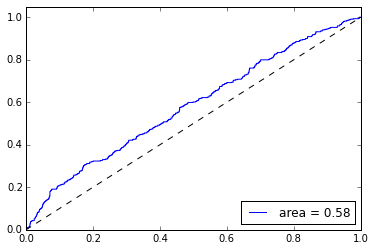

0.581291464836


In [265]:
model_LG_all= LogisticRegression(penalty ='l2',C=12)
model_LG_all.fit(train_combine, np.ravel(train_labels))

# print('f1_score: %f' %metrics.f1_score(dev_labels,model_LG.predict(dev_matrix_process_text),average='binary'))
# print('precision_score: %f' %metrics.precision_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
# print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG.predict(dev_matrix_process_text)))
# print('accuracy_score: %f' %metrics.accuracy_score(dev_labels,model_LG.predict(dev_matrix_process_text)))

preds = model_LG_all.predict(dev_combine)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = model_LG_all.predict_proba(dev_combine)

#Call to display outputs
model_output(pred_probas, F_Score, preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)

###narrative

In [272]:

train_all = train_text+train_title
dev_all = dev_text+dev_title

In [266]:
desire = re.compile(r'(friend|party|birthday|boyfriend|girlfriend|date|drinks|drunk|wasted|invite|invited|celebrate|celebrating|game|games|movie|beer|crave|craving)', re.IGNORECASE)
family = re.compile(r'(husband|wife|family|parent|parents|mother|father|mom|mum|son|dad|daughter)', re.IGNORECASE)
job = re.compile(r'(job|unemployment|employment|hire|hired|fired|interview|work|paycheck)', re.IGNORECASE)
money = re.compile(r'(money|bill|bills|rent|bank|account|paycheck|due|broke|bills|deposit|cash|dollar|dollars|bucks|paid|payed|buy|check|spent|financial|poor|loan|\
credit|budget|day|now|time|week|until|last|month|tonight|today|next|night|when|tomorrow|first|after|while|before|long|hour|Friday|ago|still|due|past|soon|current|years|never|till|yesterday|morning|evening)', re.IGNORECASE)
student = re.compile(r'(college|student|university|finals|study|studying|class|semester|school|roommate|project|tuition|dorm)', re.IGNORECASE)
mood = re.compile(r'(thank|nice|like|best|great|surprise)', re.IGNORECASE) 




In [269]:
def myfunc(a,b):
    if len(a)==0:
        return 0 
    else:
        return len(b.findall(a))/float(len(a))



In [273]:
narrative_all=np.ndarray(shape=(len(train_text),5),dtype=int)
narrative_all_dev=np.ndarray(shape=(len(dev_text),5),dtype=int)

for index,i in enumerate([desire,family,job,money,student]):
    
    vfunc = np.vectorize(myfunc)
    narrative=vfunc(train_all,i)
    narrative_dev=vfunc(dev_all,i)
    med=np.median(narrative)
    narrative_all[:,index]=np.where(narrative>med,1,0)
    narrative_all_dev[:,index]=np.where(narrative_dev>med,1,0)
    


In [286]:


# np.hstack((word_matrix_process, narrative_all))
# word_matrix_process+narrative_all
a=np.concatenate((train_matrix_process_text.toarray(), narrative_all), axis=1)
b=np.concatenate((dev_matrix_process_text.toarray(), narrative_all_dev), axis=1)

In [276]:
print(train_matrix_process_text.shape) 
print(dev_matrix_process_text.shape) 
print(a.shape) 
print(b.shape) 

(3975, 5480)
(1696, 5480)
(3975, 5485)
(1696, 5485)


Logistic regression on numeric data: F-Score = 0.0223: 
Accuracy = 0.7417
accuracy_score: 0.555556
recall_score: 0.011390
roc_auc_score: 0.504103670923
auc: 0.63


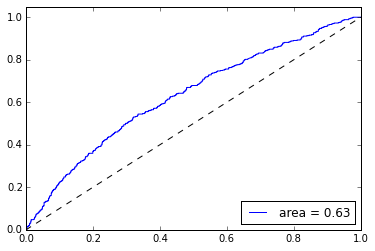

0.630541858531


In [317]:
def empty_preprocessor(s):
    return s


# vectorizer_process = CountVectorizer(preprocessor =empty_preprocessor,analyzer='word',stop_words='english' )
# word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
# dev_matrix_process = vectorizer_process.transform(dev_all)

# a=np.concatenate((word_matrix_process.toarray(), narrative_all), axis=1)
# b=np.concatenate((dev_matrix_process.toarray(), narrative_all_dev), axis=1)

model_LG = LogisticRegression(penalty ='l2',C=0.3)
model_LG.fit(a, np.ravel(train_labels))

preds = model_LG.predict(b)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = model_LG.predict_proba(b)

#Call to display outputs
model_output(pred_probas, F_Score, preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)

Logistic regression on numeric data: F-Score = 0.0090: 
Accuracy = 0.7412
accuracy_score: 0.500000
recall_score: 0.004556
roc_auc_score: 0.50148235938
auc: 0.63


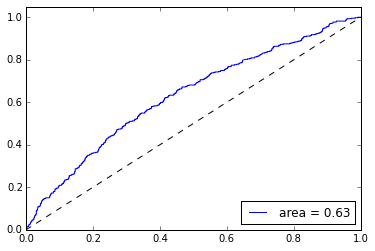

0.630142273881


In [326]:
np.random.seed(0)

# vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = empty_preprocessor)
# word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
# dev_matrix_process = vectorizer_process.transform(dev_all)

# a=np.concatenate((word_matrix_process.toarray(), narrative_all), axis=1)
# b=np.concatenate((dev_matrix_process.toarray(), narrative_all_dev), axis=1)

model_LG_L1 = LogisticRegression(penalty ='l1',C=14)#C from the above test
model_LG_L1.fit(a, np.ravel(train_labels))

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)
            
model_LG = LogisticRegression(penalty ='l2',C=0.3)#C from the above test
model_LG.fit(a[:,index], np.ravel(train_labels))

preds = model_LG.predict(b[:,index])
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')
pred_probas = model_LG.predict_proba(b[:,index])

#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)